In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from skimage import io
from skimage.filters import gaussian

import time
import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
from scipy.ndimage import uniform_filter, zoom
import hyperspy.api as hs
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, clear_output

In [3]:
import itertools
import random

def generate_architectures(num_architectures=10):
    architectures = []
    for _ in range(num_architectures):
        num_layers = random.randint(3, 5)
        encoder_layers = []
        decoder_layers = []
        
        current_channels = 1
        for i in range(num_layers):
            out_channels = 2 ** (random.randint(5, 8))  # 32 to 256
            kernel_size = random.choice([3, 5])
            stride = 2 if i < num_layers - 1 else 1
            encoder_layers.append((out_channels, kernel_size, stride))
            current_channels = out_channels
        
        for i in range(num_layers):
            out_channels = current_channels // 2 if i < num_layers - 1 else 1
            kernel_size = random.choice([3, 5, 6])
            stride = 2 if i > 0 else 1
            decoder_layers.append((out_channels, kernel_size, stride))
            current_channels = out_channels
        
        architectures.append((encoder_layers, decoder_layers[::-1]))
    
    return architectures

class FlexibleCVAE3D(nn.Module):
    def __init__(self, latent_dim, encoder_layers, decoder_layers):
        super(FlexibleCVAE3D, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = self._build_encoder(encoder_layers)
        self.fc_mu = nn.Linear(self._get_conv_output_size(), latent_dim)
        self.fc_logvar = nn.Linear(self._get_conv_output_size(), latent_dim)
        
        # Decoder
        self.decoder = self._build_decoder(decoder_layers)
        
    def _build_encoder(self, layers):
        modules = []
        in_channels = 1
        for out_channels, kernel_size, stride in layers:
            modules.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2))
            modules.append(nn.ReLU())
            in_channels = out_channels
        return nn.Sequential(*modules)
    
    def _build_decoder(self, layers):
        modules = []
        for i, (out_channels, kernel_size, stride) in enumerate(layers):
            if i == 0:
                modules.append(nn.Linear(self.latent_dim, out_channels * 27 * 27 * 32))
                modules.append(nn.ReLU())
                modules.append(nn.Unflatten(1, (out_channels, 27, 27, 32)))
            if i > 0:
                in_channels = layers[i-1][0]
                modules.append(nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, output_padding=stride-1))
                modules.append(nn.ReLU() if i < len(layers) - 1 else nn.Identity())
        return nn.Sequential(*modules)
    
    def _get_conv_output_size(self):
        x = torch.zeros(1, 1, 210, 210, 200)
        x = self.encoder(x)
        return x.numel()
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def train_and_evaluate(model, train_loader, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_recon, mean, logvar = model(x)
            loss = compute_loss(model, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        if train_loss < best_loss:
            best_loss = train_loss
    
    return best_loss

def neural_architecture_search(train_loader, latent_dim, num_architectures=10, epochs_per_model=10):
    architectures = generate_architectures(num_architectures)
    best_architecture = None
    best_loss = float('inf')
    
    for i, (encoder_layers, decoder_layers) in enumerate(architectures):
        print(f"Training architecture {i+1}/{num_architectures}")
        model = FlexibleCVAE3D(latent_dim, encoder_layers, decoder_layers)
        loss = train_and_evaluate(model, train_loader, num_epochs=epochs_per_model)
        
        if loss < best_loss:
            best_loss = loss
            best_architecture = (encoder_layers, decoder_layers)
        
        print(f"Architecture {i+1} loss: {loss:.4f}")
    
    return best_architecture, best_loss

In [4]:
class CVAE3D(nn.Module):
    """Convolutional variational autoencoder for 210x210x250 input with exact size matching."""

    def __init__(self, latent_dim):
        super(CVAE3D, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=2),  # Output: 32x105x105x125
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=5, stride=2, padding=2),  # Output: 64x53x53x63
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: 128x27x27x32 drop to 64 
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: 256x27x27x32 drop to 64 by 64  
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 27 * 27 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 27 * 27 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 27, 27, 32)),
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1),  # Output: 128x27x27x32
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=6, stride=2, padding=2, output_padding=1),  # Output: 64x53x53x63
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=6, stride=2, padding=2, output_padding=1),  # Output: 32x105x105x125
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=6, stride=2, padding=2, output_padding=1),  # Output: 1x210x210x250
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar
            
#! kernel of 5 and stride of 1, another layer, confirm there is no compression in the energy direction. 

############################################################################################################
##################################### END OF MODEL DEFINITION ##############################################
############################################################################################################

def load_dm4_data(filepath):
    s = hs.load(filepath)
    data = s.data  # The 3D data array
    return data

def preprocess_3d_images(image, target_size, sigma, energy_range, xy_window):

    """
    Preprocess 3D images with arbitrary input and output dimensions.
    
    :param image: Input 3D image (height, width, depth)
    :param target_size: Tuple of (height, width, depth) for the target size
    :param sigma: Sigma for Gaussian blur
    :param energy_range: Tuple of (min_energy, max_energy) in eV
    :param xy_window: Window size for spatial-spectral smoothing
    :return: Tuple of (preprocessed_image, reshaped_image)
    """
    # Apply Gaussian blur
    blurred_image = gaussian(image, sigma=sigma, mode='reflect', preserve_range=True)
    
    # Calculate the pixel indices corresponding to the energy range
    start_pixel = int(energy_range[0])
    end_pixel = int(energy_range[1])
    
    # Slice the data array to keep only the desired energy range in the depth dimension
    blurred_image = blurred_image[:, :, start_pixel:end_pixel]
    
    # Normalize the image
    normalized_image = blurred_image / np.max(blurred_image)
    
    # Apply spatial-spectral smoothing
    def smooth_spatial_spectral(arr, window):
        neighborhood_sum = uniform_filter(arr, size=(window, window, 1), mode='reflect')
        neighborhood_count = uniform_filter(np.ones_like(arr), size=(window, window, 1), mode='reflect')
        return neighborhood_sum / neighborhood_count
    
    smoothed_img = smooth_spatial_spectral(normalized_image, xy_window)
    
    # Resize the image to match the target size
    current_size = smoothed_img.shape
    scale_factors = [t / c for t, c in zip(target_size, current_size)]
    
    resized_img = zoom(smoothed_img, scale_factors, order=1)  # order=1 for linear interpolation
    
    # Ensure the final shape matches the target size
    assert resized_img.shape == target_size, f"Shape mismatch: {resized_img.shape} != {target_size}"
    
    # Reshape to (1, 1, height, width, depth) for PyTorch
    reshaped_image = resized_img.reshape((1, 1, *target_size))
    
    return resized_img, reshaped_image.astype('float32')

############################################################################################################
##################################### END OF DATA PREPROCESSING ############################################
############################################################################################################
    
def compute_loss(model, x):
    x_recon, mean, logvar = model(x)
    recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def log_normal_pdf(sample, mean, logvar):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(-0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), dim=1)

def gaussian_blur(img, sigma):
    return np.array(gaussian(img, (sigma, sigma)))

def gaussian_blur_arr(images, sigma):
    return np.array([gaussian_blur(img, sigma) for img in images])

def norm_max_pixel(images):
    return np.array([img / np.max(img) for img in images])

def visualize_inference(model, input_image, data, energy_range, x = 0, y = 0):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_image).unsqueeze(0).to(device)
        mean, logvar = model.encode(input_tensor)
        z = model.reparameterize(mean, logvar)
        prediction = model.decode(z)

    # Set the pixel manually
    selected_pixel = (y, x) #! SET THE PIXEL MANUALLY 

    # Create two separate figures
    fig_images = make_subplots(rows=1, cols=2, subplot_titles=('Input Image', 'Prediction'))
    fig_spectra = make_subplots(rows=1, cols=2, subplot_titles=('Input Spectral Graph', 'Predicted Spectral Graph'))

    # Input Image
    middle_slice_input = input_image[0, :, :, input_image.shape[2] // 2].cpu().numpy()
    fig_images.add_trace(go.Heatmap(z=middle_slice_input, colorscale='Viridis', showscale=False), row=1, col=1)
    fig_images.add_trace(go.Scatter(x=[selected_pixel[1]], y=[selected_pixel[0]], mode='markers', 
                                    marker=dict(color='red', size=10), showlegend=False), row=1, col=1)

    # Prediction
    middle_slice_prediction = prediction[0, 0, :, :, prediction.shape[2] // 2].cpu().numpy()
    fig_images.add_trace(go.Heatmap(z=middle_slice_prediction, colorscale='Viridis', showscale=False), row=1, col=2)
    fig_images.add_trace(go.Scatter(x=[selected_pixel[1]], y=[selected_pixel[0]], mode='markers', 
                                    marker=dict(color='red', size=10), showlegend=False), row=1, col=2)

    # Update layout to ensure images are not distorted
    fig_images.update_layout(
        height=600,
        width=1200,
        margin=dict(l=20, r=20, t=40, b=20),
        yaxis=dict(scaleanchor="x", scaleratio=1),
        yaxis2=dict(scaleanchor="x2", scaleratio=1)
    )

    # Input Spectral Graph
    input_spectrum = data[selected_pixel[0], selected_pixel[1], :]
    x_energy = np.linspace(energy_range[0], energy_range[1], input_spectrum.shape[0])
    fig_spectra.add_trace(go.Scatter(x=x_energy, y=input_spectrum), row=1, col=1)

    # Predicted Spectral Graph
    predicted_spectrum = prediction[0, 0, selected_pixel[0], selected_pixel[1], :].cpu().numpy()
    fig_spectra.add_trace(go.Scatter(x=x_energy, y=predicted_spectrum), row=1, col=2)

    fig_spectra.update_layout(
        height=500,
        width=1200,
        margin=dict(l=20, r=20, t=40, b=20)
    )
    
    return fig_images, fig_spectra

def create_loss_plot():
    """Create an empty Plotly figure for the loss plot."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[], y=[], mode='lines', name='Training Loss'))
    fig.update_layout(title='Training Loss',
                      xaxis_title='Epoch',
                      yaxis_title='Loss',
                      height=400,
                      width=800)
    return fig

def spectra(data, energy_range):     
    '''Function to plot the spectra of the data''' 
    plt.plot(data[:3, :3, :].mean(axis = (0, 1)))
    
    # Calculate the pixel indices corresponding to the energy range
    start_pixel = int((energy_range[0] - 0))
    end_pixel = int((energy_range[1] - 0))

    # Slice the data array to keep only the desired energy range in the third dimension
    data = data[:, :, start_pixel:end_pixel]

    # show the shape of the data 
    print(data.shape)

    # show the shape of the data 
    plt.plot(data[:3, :3, :].mean(axis = (0, 1)))
    plt.show()

(210, 210, 200)


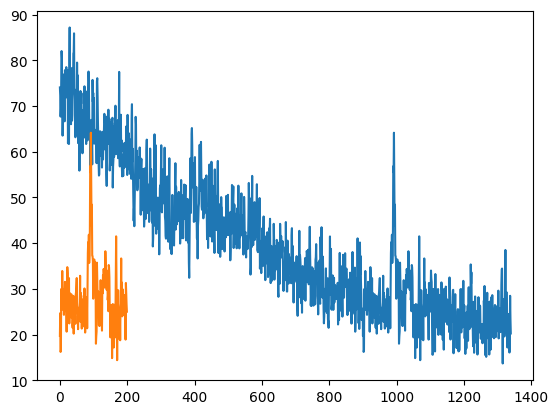

In [5]:
SIGMA = 2
epochs = 400
latent_dim = 25
energy_range = (900, 1100)  
target_size = (210, 210, energy_range[1]-energy_range[0])  # (x, y, z)
ev_per_pixel = 0.05
dm4_file = 'data/images_3D/BFO_a-0090 (dark ref corrected).dm3'

# Load the data with the specified energy range and resolution
data = load_dm4_data(dm4_file)

spectra(data, energy_range)

#! APPLY 2D Smoothing before feeding to the model 
#! generate the image where every pixel ( spectrum ) is the average of 3 by 3 pixels, also try training only on the "white part"
#! try to overtrain by making it bigger if nothing else works 

In [7]:
train_image_viz, train_image = preprocess_3d_images(data, target_size, sigma=SIGMA, energy_range=energy_range, xy_window=3)

# Create data loaders
train_dataset = TensorDataset(torch.tensor(train_image))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Perform Neural Architecture Search
best_architecture, best_loss = neural_architecture_search(train_loader, latent_dim, num_architectures=10, epochs_per_model=50)
print(f"Best architecture: {best_architecture}")
print(f"Best loss: {best_loss:.4f}")

Training architecture 1/10


KeyboardInterrupt: 